In [2]:
import glob    #fileの名前の取得に必要
import numpy as np
import re

#https://qiita.com/neet-AI/items/2b3d7f743e4d6c6d8e10
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.image import random_rotation, random_shift, random_zoom
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.models import Sequential
from keras.models import model_from_json
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import np_utils
import pandas as pd
from datetime import date
from datetime import time
from datetime import datetime
from datetime import datetime as dt

In [96]:
def csv_label_path():
    """
    data/route/*_route/*_dep/*.csvにあるcsvのpathを取得しfilesに保存
    
    return
    ------
    files : list[str]
        csvfileのpathの配列(../data/route/taketomi_route/isigaki_dep/2020-08-02.csv)
    """
    route_name_dic = {
            "taketomi_route" : ["isigaki_dep","taketomi_dep"],
            "kurosima_route" : ["isigaki_dep","kurosima_dep"],
            "kohama_route" : ["isigaki_dep","kohama_dep"],
            "iriomote_uehara_route" : ["isigaki_dep","uehara_dep"],
            "hatoma_route" : ["isigaki_dep","hatoma_dep"],
            "iriomote_ohara_route" : ["isigaki_dep","ohara_dep"],
            "hateruma_route" : ["isigaki_dep","hateruma_dep"]
        } 
    for key,value in route_name_dic.items():    #航路分回る(7回)
        #print(key,value)
        for i in value:    #出発港分回る
            #print(i)
            dir = "../data/route/" + key + "/" + i + "/*.csv"
            #print(dir)
            files = [p for p in glob.glob(dir, recursive=True)    #fileのpathを取得する
               if re.search(r'020-\d[891]-\d*.csv', p)]           #正規表現で2020-08~11分のcsvを抽出
            files.sort()
            #print(files)

        break    #まずは竹富航路までテスト

    return files

    #files = glob.glob(dirname + "/*.jpeg")
    #data/route/hateruma_route/hateruma_dep

In [97]:
def make_df(files):
    """
    csvファイルのpathからcsvを読み込みDataFrame作成
    
    parameters
    ----------
    files : list[str]
        csvファイルのpathの配列
    
    return
    ------
    df_list : list[DataFrame]
        csvの中身をdfに格納、Date,Time列の結合した列を追加
    """
    img_time_com = ["08:00:00","10:00:00","12:00:00","14:00:00","16:00:00"]
    img_time = ["07:00:00","09:00:00","11:00:00","13:00:00","15:00:00","17:00:00"]
    df_list = []
    
    for i in range(0,len(files)):    #csvのpathの数分のループを行う
        df = pd.read_csv(files[i],  names=('Time', 'Label', 'Date'))    #csvをpandasで読み込み

        #df = df.reset_index(drop=True)
        #print(df)
        df['DateTime'] = df['Date'].str.cat(df['Time'], sep=' ')    #Date,Timeの列を結合しDateTimeとして新しい列の追加
        #df['Date'] = pd.to_datetime(df['Date'])
        df['DateTime'] = pd.to_datetime(df['DateTime'])    #DateTimeをdatetime型に変換
        #print(df)
        df_list.append(df)
        
    return df_list

In [98]:
def df_loop(df_list,img_time_com,img_time,atri):
    """
    dataframeを引数にもらいdfの行数分ループしさらにimg_time_com文その中でループ
    csvのTimeに近い画像のpathをimg_path変数に格納
    
    paramenters
    -----------
    df : DataFrame
        csvをdfにしたもので中身
        列名["Time","Label","Date","DateTime"]
        要素[07:50,0,2020-08-02,2020-08-02 07:50:00]
    img_time_com : list[str]
        Timeの比較に必要な時間の配列("08:00:00","10:00:00","12:00:00","14:00:00","16:00:00")
    img_time : list[str]
        比較した結果imgのpath記述に必要な時間の文字列("07:00:00","09:00:00","11:00:00","13:00:00","15:00:00","17:00:00")
    atri : str
       wave_height,wind_speedのどちらか
    
    return
    ------
    img_path : list[str]
        画像のpathの配列
    date_list : list[str]
        参照先の画像が無い場合にdf内のlabelを削除するために日付を格納
    """
    img_path = []
    date_list = []    #画像path参照先に画像がない場合にdf内のlabelを削除するための配列

    for df in df_list:
        for row in df.itertuples():    #dfを一行ずつ回す
            #print(type(row[3]))
            #print(row.DateTime)

            #for文で回す
            for i in range(len(img_time_com)):    #画像の比較のために5回回す
               # print(len(img_time_com))
                comtime = row[3] + " " + img_time_com[i]
                #print(comtime)
                #tstr = comtime#'2012-12-29 13:49:37'
                comdatetime = dt.strptime(comtime, '%Y-%m-%d %H:%M:%S')
                #print(type(comdatetime))
                #print(comdatetime)
                #print(row.DateTime)
                #print(i)
                if row.DateTime < comdatetime:    #航路出発時間 < 画像の取得時間
                    img_path.append("../data/windy_img/"+row[3]+"/"+atri+"/"+row[3]+ " " +img_time[i]+".png")
                    date_list.append(row[3])
                    #print("../data/windy_img/"+row[3]+"/"+atri+"/"+row[3]+ " " +img_time[i]+".png")
                    #print("True")
                    break
                elif 4 == i:    #4はimg_time_comのすべてにかからなかった場合最終ループであるのことの確認
                    img_path.append("../data/windy_img/"+row[3]+"/"+atri+"/"+row[3]+ " " +img_time[5]+".png")
                    date_list.append(row[3])
                    #print("../data/windy_img/"+row[3]+"/"+atri+"/"+row[3]+ " " +img_time[5]+".png")

    return img_path,date_list

In [62]:
print(img_path)

['../data/windy_img/2020-08-02/wave_height/2020-08-02 07:00:00.png', '../data/windy_img/2020-08-02/wave_height/2020-08-02 09:00:00.png', '../data/windy_img/2020-08-02/wave_height/2020-08-02 09:00:00.png', '../data/windy_img/2020-08-02/wave_height/2020-08-02 11:00:00.png', '../data/windy_img/2020-08-02/wave_height/2020-08-02 11:00:00.png', '../data/windy_img/2020-08-02/wave_height/2020-08-02 13:00:00.png', '../data/windy_img/2020-08-02/wave_height/2020-08-02 15:00:00.png', '../data/windy_img/2020-08-02/wave_height/2020-08-02 15:00:00.png', '../data/windy_img/2020-08-02/wave_height/2020-08-02 17:00:00.png', '../data/windy_img/2020-08-02/wave_height/2020-08-02 17:00:00.png', '../data/windy_img/2020-08-02/wave_height/2020-08-02 17:00:00.png', '../data/windy_img/2020-08-03/wave_height/2020-08-03 07:00:00.png', '../data/windy_img/2020-08-03/wave_height/2020-08-03 09:00:00.png', '../data/windy_img/2020-08-03/wave_height/2020-08-03 09:00:00.png', '../data/windy_img/2020-08-03/wave_height/2020-

In [152]:
def img_load(img_path,date_list):
    """
    引数で画像のpathの配列を受け取り、pathを参照し画像のloadを行う、numpy配列歌詞appenndする
    
    parameters
    ----------
    img_path : list[str]
        画像のpathの配列
    
    return
    ------
    arrlist : list[numpy]
        画像の任意sizeの配列を
    err_date : list[str]
        画像がない場合にdfから画像の無い日付を削除するための配列
    """
    arrlist = []    #imgのnumpy行列
    err_date = []
    hw = {"height":32, "width":32}        #画像のサイズ
    for i in range(0,len(img_path)):
        try:
            img = load_img(img_path[i], target_size=(hw["height"], hw["width"]))    # 画像ファイルの読み込み
            array = img_to_array(img) / 255                                     # 画像ファイルのnumpy化
            arrlist.append(array)  
            
        except FileNotFoundError as e:    #画像のfileが無い場合エラーを出力して無視
            print('FileNotFoundError:', e)
            err_date.append(date_list[i])
            
    return arrlist,err_date

In [153]:
files = csv_label_path()                              #csvのpathの取得
df_list = make_df(files)                                   #csvからdfの作成
atri = "wave_height"                                  #波の高さの画像のみ取得
img_path,date_list = df_loop(df_list,img_time_com,img_time,atri)     #画像のpath取得
arrlist,err_date = img_load(img_path,date_list)                          #画像の行列の取得


FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-08-02/wave_height/2020-08-02 07:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-08-02/wave_height/2020-08-02 09:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-08-02/wave_height/2020-08-02 09:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-08-02/wave_height/2020-08-02 11:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-08-02/wave_height/2020-08-02 11:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-08-02/wave_height/2020-08-02 13:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-08-02/wave_height/2020-08-02 15:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-08-02/wave_height/2020-08-02 15:00:00.png'
FileNotFoundErro

FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-01/wave_height/2020-11-01 07:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-01/wave_height/2020-11-01 09:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-01/wave_height/2020-11-01 09:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-01/wave_height/2020-11-01 11:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-01/wave_height/2020-11-01 11:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-01/wave_height/2020-11-01 13:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-01/wave_height/2020-11-01 15:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-01/wave_height/2020-11-01 15:00:00.png'
FileNotFoundErro

FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 07:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 09:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 09:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 11:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 11:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 13:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 15:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 15:00:00.png'
FileNotFoundErro

In [154]:
df = df_list[0]
for i in range(0,len(df_list)):
    df = pd.concat([df, df_list[i]], axis=0)
#print(df)

for i in err_date:
    #print(i)
    df = df[df["Date"] != i]
df = df.reset_index(drop=True)
print(df)

      Time  Label        Date            DateTime
0    07:50      0  2020-08-08 2020-08-08 07:50:00
1    08:50      0  2020-08-08 2020-08-08 08:50:00
2    09:50      0  2020-08-08 2020-08-08 09:50:00
3    10:50      0  2020-08-08 2020-08-08 10:50:00
4    11:50      0  2020-08-08 2020-08-08 11:50:00
..     ...    ...         ...                 ...
614  15:20      0  2020-11-10 2020-11-10 15:20:00
615  16:20      0  2020-11-10 2020-11-10 16:20:00
616  16:50      0  2020-11-10 2020-11-10 16:50:00
617  17:20      0  2020-11-10 2020-11-10 17:20:00
618  17:50      0  2020-11-10 2020-11-10 17:50:00

[619 rows x 4 columns]


In [155]:
df1 = df[df["Label"] != 0]
print(df1)
print("総数\n{}".format(len(df)))
print("欠航の数\n{}".format(len(df1)))
df2 = df[df["Label"] != 1]
print("運行の数\n{}".format(len(df2)))

      Time  Label        Date            DateTime
161  15:20      1  2020-08-22 2020-08-22 15:20:00
162  16:20      1  2020-08-22 2020-08-22 16:20:00
163  17:20      1  2020-08-22 2020-08-22 17:20:00
164  18:20      1  2020-08-22 2020-08-22 18:20:00
165  07:50      1  2020-08-23 2020-08-23 07:50:00
169  11:50      1  2020-08-23 2020-08-23 11:50:00
170  13:20      1  2020-08-23 2020-08-23 13:20:00
171  14:20      1  2020-08-23 2020-08-23 14:20:00
172  15:20      1  2020-08-23 2020-08-23 15:20:00
173  16:20      1  2020-08-23 2020-08-23 16:20:00
174  17:20      1  2020-08-23 2020-08-23 17:20:00
175  18:20      1  2020-08-23 2020-08-23 18:20:00
255  09:50      1  2020-08-31 2020-08-31 09:50:00
256  10:50      1  2020-08-31 2020-08-31 10:50:00
257  11:50      1  2020-08-31 2020-08-31 11:50:00
258  13:20      1  2020-08-31 2020-08-31 13:20:00
259  14:20      1  2020-08-31 2020-08-31 14:20:00
260  15:20      1  2020-08-31 2020-08-31 15:20:00
261  16:20      1  2020-08-31 2020-08-31 16:20:00


In [156]:
nplist = np.array(arrlist)
filename = "wave_heghit"
np.save(filename, nplist)
print(">> data/route/windy_imgから" + str(len(nplist)) + "個のファイル読み込み成功")

>> data/route/windy_imgから619個のファイル読み込み成功


In [159]:
#print(arrlist)
nplist
print(type(nplist))
print("画像数,size縦,size横,RGB",nplist.shape)
print("行列の総数",nplist.size)
#print(50000*32*32*3)
print(len(nplist))

<class 'numpy.ndarray'>
画像数,size縦,size横,RGB (619, 32, 32, 3)
行列の総数 1901568
619


In [223]:
y = df['Label'].values
y = np.array(y).reshape(-1, 1).tolist()
#print(y)
print(type(y))
y_test = y[172:262]
y_train = np.concatenate([y[0:172], y[262:]])

print("y_train\n{}\ny_train {}".format(y_train,len(y_train)))
print("y_test\n{}\ny_test {}".format(y_test,len(y_test)))
#print(y_train)

<class 'list'>
y_train
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [

In [209]:
nb_classes = 2

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)
print(y_train)
print(y_test.shape)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
(90, 2)


In [222]:
X = nplist
print(type(X))
X_test = X[172:262]
X_train = np.concatenate([X[0:172], X[262:]])

print("X_train\n{}".format(len(X_train)))
print("X_test\n{}".format(len(X_test)))
print(X_train)

<class 'numpy.ndarray'>
X_train
529
X_test
90
[[[[0.16862746 0.2901961  0.40392157]
   [0.23529412 0.40784314 0.56078434]
   [1.         1.         1.        ]
   ...
   [0.25490198 0.27450982 0.3019608 ]
   [0.25490198 0.27450982 0.3019608 ]
   [0.25490198 0.27450982 0.3019608 ]]

  [[0.12941177 0.23137255 0.31764707]
   [0.23921569 0.41960785 0.57254905]
   [1.         1.         1.        ]
   ...
   [0.22745098 0.3882353  0.54509807]
   [0.22745098 0.3882353  0.54509807]
   [0.25490198 0.27450982 0.3019608 ]]

  [[0.23921569 0.41960785 0.57254905]
   [0.23921569 0.42745098 0.5764706 ]
   [0.23921569 0.42745098 0.5764706 ]
   ...
   [0.22745098 0.3882353  0.54509807]
   [0.22745098 0.3882353  0.54509807]
   [0.22745098 0.3882353  0.54509807]]

  ...

  [[0.23529412 0.4        0.6117647 ]
   [0.25882354 0.27450982 0.30980393]
   [0.25882354 0.27450982 0.30980393]
   ...
   [0.24313726 0.40784314 0.6745098 ]
   [0.24313726 0.40784314 0.6745098 ]
   [0.24313726 0.40784314 0.6784314 ]]


In [211]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.utils import plot_model, to_categorical
from keras.callbacks import TensorBoard
# モデルの定義
model = Sequential()

model.add(Conv2D(32,3,input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(Conv2D(32,3))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64,3))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))#1.0

model.add(Dense(nb_classes, activation='softmax'))

adam = Adam(lr=1e-4)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
activation_115 (Activation)  (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_116 (Activation)  (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
activation_117 (Activation)  (None, 12, 12, 64)      

In [212]:
#エポック数　100
nb_epoch = 10

#バッチサイズ　500
batch_size = 500

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_split=0.1)

Epoch 1/10
1/1 [==============================] - 0s 223ms/step - loss: 0.6969 - accuracy: 0.4832 - val_loss: 0.5294 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 37ms/step - loss: 0.5419 - accuracy: 0.9517 - val_loss: 0.3909 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 0.4197 - accuracy: 0.9559 - val_loss: 0.2826 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 33ms/step - loss: 0.3287 - accuracy: 0.9559 - val_loss: 0.2005 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 35ms/step - loss: 0.2662 - accuracy: 0.9559 - val_loss: 0.1405 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.2199 - accuracy: 0.9559 - val_loss: 0.0981 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 41ms/step - loss: 0.1926 - accuracy: 0.9559 - val_loss: 0.0690 - val_accuracy: 1.0000
Epoch 8/10
1/1 [==========

In [213]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))


In [215]:
optimizers ="Adadelta"
results = {}
epochs = 10
model.compile(loss='categorical_crossentropy', optimizer=optimizers, metrics=['accuracy'])
results= model.fit(X_train, y_train, validation_split=0.2, epochs=epochs )

model_json_str = model.to_json()
open('mnist_mlp_model.json', 'w').write(model_json_str)
model.save_weights('mnist_mlp_weights.h5');

Epoch 1/10
14/14 [==============================] - 1s 74ms/step - loss: 0.5616 - accuracy: 0.8818 - val_loss: 0.5614 - val_accuracy: 1.0000
Epoch 2/10
14/14 [==============================] - 1s 77ms/step - loss: 0.5382 - accuracy: 0.9243 - val_loss: 0.5449 - val_accuracy: 1.0000
Epoch 3/10
14/14 [==============================] - 1s 77ms/step - loss: 0.5206 - accuracy: 0.9385 - val_loss: 0.5288 - val_accuracy: 1.0000
Epoch 4/10
14/14 [==============================] - 1s 75ms/step - loss: 0.4991 - accuracy: 0.9433 - val_loss: 0.5133 - val_accuracy: 1.0000
Epoch 5/10
14/14 [==============================] - 1s 77ms/step - loss: 0.4854 - accuracy: 0.9409 - val_loss: 0.4981 - val_accuracy: 1.0000
Epoch 6/10
14/14 [==============================] - 1s 82ms/step - loss: 0.4745 - accuracy: 0.9504 - val_loss: 0.4828 - val_accuracy: 1.0000
Epoch 7/10
14/14 [==============================] - 1s 78ms/step - loss: 0.4591 - accuracy: 0.9504 - val_loss: 0.4675 - val_accuracy: 1.0000
Epoch 8/10
14

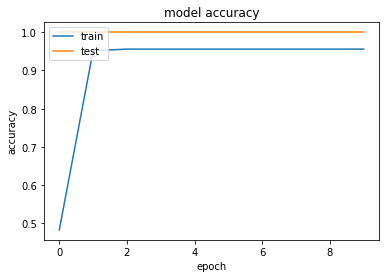

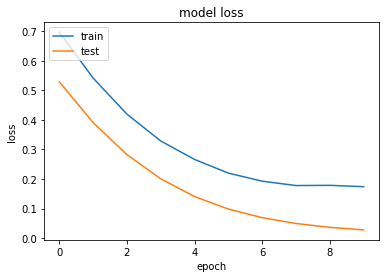

In [221]:
import matplotlib.pyplot as plt
#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [49]:
def main():
    files = csv_label_path()                              #csvのpathの取得
    df = make_df(files)                                   #csvからdfの作成
    atri = "wave_height"                                  #波の高さの画像のみ取得
    img_path = df_loop(df,img_time_com,img_time,atri)     #画像のpath取得
    arrlist = img_load(img_path)                          #画像の行列の取得
    nplist = np.array(arrlist)
    filename = "wave_heghit"
    np.save(filename, nplist)
    #print(">> " + dirname + "から" + str(num) + "個のファイル読み込み成功")

In [50]:
if __name__ == '__main__':
    main()

isigaki_dep
../data/route/taketomi_route/isigaki_dep/*.csv
['../data/route/taketomi_route/isigaki_dep/2020-08-02.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-03.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-04.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-05.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-06.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-07.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-08.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-09.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-10.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-11.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-12.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-13.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-14.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-15.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-16.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-17.cs

<class 'str'>
2020-08-02 07:50:00
../data/windy_img/2020-08-02/wave_height/2020-08-02 07:00:00.png
True
<class 'str'>
2020-08-02 08:50:00
../data/windy_img/2020-08-02/wave_height/2020-08-02 09:00:00.png
True
<class 'str'>
2020-08-02 09:50:00
../data/windy_img/2020-08-02/wave_height/2020-08-02 09:00:00.png
True
<class 'str'>
2020-08-02 10:50:00
../data/windy_img/2020-08-02/wave_height/2020-08-02 11:00:00.png
True
<class 'str'>
2020-08-02 11:50:00
../data/windy_img/2020-08-02/wave_height/2020-08-02 11:00:00.png
True
<class 'str'>
2020-08-02 13:20:00
../data/windy_img/2020-08-02/wave_height/2020-08-02 13:00:00.png
True
<class 'str'>
2020-08-02 14:20:00
../data/windy_img/2020-08-02/wave_height/2020-08-02 15:00:00.png
True
<class 'str'>
2020-08-02 15:20:00
../data/windy_img/2020-08-02/wave_height/2020-08-02 15:00:00.png
True
<class 'str'>
2020-08-02 16:20:00
../data/windy_img/2020-08-02/wave_height/2020-08-02 17:00:00.png
<class 'str'>
2020-08-02 17:20:00
../data/windy_img/2020-08-02/wave_h

<class 'str'>
2020-09-04 08:50:00
../data/windy_img/2020-09-04/wave_height/2020-09-04 09:00:00.png
True
<class 'str'>
2020-09-04 09:50:00
../data/windy_img/2020-09-04/wave_height/2020-09-04 09:00:00.png
True
<class 'str'>
2020-09-04 10:50:00
../data/windy_img/2020-09-04/wave_height/2020-09-04 11:00:00.png
True
<class 'str'>
2020-09-04 11:50:00
../data/windy_img/2020-09-04/wave_height/2020-09-04 11:00:00.png
True
<class 'str'>
2020-09-04 13:20:00
../data/windy_img/2020-09-04/wave_height/2020-09-04 13:00:00.png
True
<class 'str'>
2020-09-04 14:20:00
../data/windy_img/2020-09-04/wave_height/2020-09-04 15:00:00.png
True
<class 'str'>
2020-09-04 15:20:00
../data/windy_img/2020-09-04/wave_height/2020-09-04 15:00:00.png
True
<class 'str'>
2020-09-04 16:20:00
../data/windy_img/2020-09-04/wave_height/2020-09-04 17:00:00.png
<class 'str'>
2020-09-04 17:20:00
../data/windy_img/2020-09-04/wave_height/2020-09-04 17:00:00.png
<class 'str'>
2020-09-04 18:20:00
../data/windy_img/2020-09-04/wave_height

True
<class 'str'>
2020-09-28 13:20:00
../data/windy_img/2020-09-28/wave_height/2020-09-28 13:00:00.png
True
<class 'str'>
2020-09-28 14:20:00
../data/windy_img/2020-09-28/wave_height/2020-09-28 15:00:00.png
True
<class 'str'>
2020-09-28 15:20:00
../data/windy_img/2020-09-28/wave_height/2020-09-28 15:00:00.png
True
<class 'str'>
2020-09-28 16:20:00
../data/windy_img/2020-09-28/wave_height/2020-09-28 17:00:00.png
<class 'str'>
2020-09-28 17:20:00
../data/windy_img/2020-09-28/wave_height/2020-09-28 17:00:00.png
<class 'str'>
2020-09-28 18:20:00
../data/windy_img/2020-09-28/wave_height/2020-09-28 17:00:00.png
<class 'str'>
2020-09-29 07:50:00
../data/windy_img/2020-09-29/wave_height/2020-09-29 07:00:00.png
True
<class 'str'>
2020-09-29 08:50:00
../data/windy_img/2020-09-29/wave_height/2020-09-29 09:00:00.png
True
<class 'str'>
2020-09-29 09:50:00
../data/windy_img/2020-09-29/wave_height/2020-09-29 09:00:00.png
True
<class 'str'>
2020-09-29 10:50:00
../data/windy_img/2020-09-29/wave_height

FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-09-22/wave_height/2020-09-22 07:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-09-22/wave_height/2020-09-22 09:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-09-22/wave_height/2020-09-22 09:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-09-22/wave_height/2020-09-22 11:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-09-22/wave_height/2020-09-22 11:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-09-22/wave_height/2020-09-22 13:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-09-22/wave_height/2020-09-22 15:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-09-22/wave_height/2020-09-22 15:00:00.png'
FileNotFoundErro

FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 07:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 09:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 09:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 11:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 11:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 13:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 15:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 15:00:00.png'
FileNotFoundErro